# Machine Learning 

In [1]:
import pandas as pd
import numpy as np
import time
import machine_learning_helper as machine_learning_helper
import metrics_helper as metrics_helper
import sklearn.neighbors, sklearn.linear_model, sklearn.ensemble, sklearn.naive_bayes
from sklearn.model_selection import KFold, train_test_split, ShuffleSplit
from sklearn import model_selection
from sklearn import ensemble
from xgboost.sklearn import XGBClassifier
import scipy as sp
import xgboost as xgb
import matplotlib.pyplot as plt 
% matplotlib inline
from sklearn.model_selection import learning_curve

## Read .csv files

In [2]:
df_train_users = pd.read_csv("cleaned_train_user.csv")
df_test_users = pd.read_csv("cleaned_test_user.csv")
df_time_mean_user_id = pd.read_csv("time_mean_user_id.csv")
df_time_total_user_id = pd.read_csv("time_total_user_id.csv")
df_total_action_user_id = pd.read_csv("total_action_user_id.csv")

## Construct sessions data frame

In [3]:
df_total_action_user_id.columns = ['id','action']
df_sessions = pd.merge(df_time_mean_user_id, df_time_total_user_id, on='id', how='outer')
df_sessions = pd.merge(df_sessions, df_total_action_user_id, on='id', how='outer')
df_sessions.columns = ['id','time_mean_user','time_total_user','action']
df_sessions.head()

print("X_train has dimension:",df_train_users.shape)
print("X_test has dimension:",df_test_users.shape)

X_train has dimension: (213451, 16)
X_test has dimension: (62096, 15)


## 1. From data frame to matrix : Construct y_train

What we want now for the training is 2 matrices X_train (matrix of relevant features) and y_train (booking dest)

In [4]:
y_labels, label_enc = machine_learning_helper.buildTargetMat(df_train_users)

## 2. From data frame to matrix : Construct X_train & X_test

### Feature engineering.
Add 3 features : 
- time_mean_user
- time_total_user
- total_action_user


In [5]:
df_train_len = df_train_users.shape[0]
df_train = df_train_users.drop(['country_destination'],axis=1)
df_all = pd.concat((df_train_users, df_test_users), axis=0, ignore_index=True)
df_all = pd.merge(df_all, df_sessions, on='id', how='left', left_index=True)

In [6]:
X_train, X_test = machine_learning_helper.buildFeatsMat(df_train_users, df_test_users, df_sessions)

## 3. Cross validation setup
5 folds cross validation, using ndcg as scoring metric.


In [7]:
#X_train = X_train[100000:101000]
#y_labels = y_labels[100000:101000]

# Split train dataset into 5 folds, completely shuffled
cv = model_selection.KFold(n_splits=5, random_state=None, shuffle=True)
for train_id, test_id in cv.split(X_train):
    print(train_id, test_id)

[     0      1      2 ..., 213448 213449 213450] [     3      9     11 ..., 213435 213442 213444]
[     0      1      2 ..., 213444 213446 213447] [    12     14     17 ..., 213448 213449 213450]
[     0      2      3 ..., 213448 213449 213450] [     1      7     10 ..., 213437 213446 213447]
[     1      3      6 ..., 213448 213449 213450] [     0      2      4 ..., 213439 213440 213443]
[     0      1      2 ..., 213448 213449 213450] [     6     15     19 ..., 213425 213433 213441]


# 4. Machine Learning 
First several algorithms are tried, and optimized through Cross validation and Grid Search. The code is here optimized to run on 3 processors at the same time, as it is very long. See here examples on MacBook Pro 4 cpu, RAM 16GB
Computational time
GridsearchCrossValidation:

- 5000 data
    Random Forest : 27 fits 10,1s
    XGB : 36 fits 60s
    
- 10000 data
    Random Forest : 27 fits 22 s
    XGB : 36 fits 140s
    
- 50000 data
    Random Forest : 27 fits 342
    XGB : 36 fits 1100s

Our final model is composed of a voting classifier composed of the previous models optimized.


Models that were tried:
- **Random Forest** with the following parameters:

    - 'max_depth': [ 4, 6, 8]
    - 'n_estimators': [ 50, 100, 150]


- **eXtreme Gradient Boosting XCGB**:
    - 'max_depth': [6,8,10],
    - 'learning_rate': [0.3],
    - 'n_estimators': [10,15,20,25],
    - 'objective': ['multi:softprob'],
    - 'gamma': [0],
    - 'subsample': [0.5],
    - 'colsample_bytree': [0.5],
    - 'seed': [0]

- Voting classifer:
    - Soft 
    
The metric used is the nDCG.

# Model 1 : RandomForest

Grid Search to find best parameter.

In [8]:
X_train_sparse = sp.sparse.csr_matrix(X_train.values)

In [ ]:
number_trees = [125, 300, 500, 600  ]
max_depth = [5, 8, 12, 16, 20]

rf_score_trees = []
rf_score_depth = []
rf_param_trees = []
rf_param_depth = []

#Loop for 1st hyperparameter n_estimators
for number_trees_idx, number_trees_value in enumerate(number_trees):
    
    print('number_trees_idx: ',number_trees_idx+1,'/',len(number_trees),', value: ', number_trees_value)

    # Random forest
    rand_forest_model = ensemble.RandomForestClassifier(n_estimators=number_trees_value, max_depth=14)

    #Scores
    scores = model_selection.cross_val_score(rand_forest_model, X_train_sparse, y_labels, cv=cv, verbose = 10, n_jobs = 12, scoring=metrics_helper.ndcg_scorer)
    rf_score_trees.append(scores.mean())
    rf_param_trees.append(number_trees_value)
    print('Mean NDCG for this number_trees = ', scores.mean())

# best number of trees from above
print() 
print('best NDCG:')
print(np.max(rf_score_trees))
print('best parameter num_trees:')
idx_best = np.argmax(rf_score_trees)
best_num_trees_RF = rf_param_trees[idx_best]
print(best_num_trees_RF)

In [ ]:
#Loop for  hyperparameter max_depth
for max_depth_idx, max_depth_value in enumerate(max_depth):
    
    print('max_depth_idx: ',max_depth_idx+1,'/',len(max_depth),', value: ', max_depth_value)

    # Random forest
    rand_forest_model = ensemble.RandomForestClassifier(n_estimators=best_num_trees_RF, max_depth=max_depth_value)

    #Scores
    scores = model_selection.cross_val_score(rand_forest_model, X_train_sparse, y_labels, cv=cv, verbose = 10, n_jobs = 12, scoring=metrics_helper.ndcg_scorer)
    rf_score_depth.append(scores.mean())
    rf_param_depth.append(max_depth_value)
    print('Mean NDCG for this max:_depth = ', scores.mean())
    
# best max_depth from above
print() 
print('best NDCG:')
print(np.max(rf_score_depth))
print('best parameter max_depth:')
idx_best = np.argmax(rf_score_depth)
best_max_depth_RF = rf_param_depth[idx_best]
print(best_max_depth_RF)

Random forest 600 trees, 16 depth NDCG = 0.821472784776

## Predict Countries and convert to CSV for submision for RF model

In [ ]:
best_num_trees_RF = 600
best_max_depth_RF = 16

rand_forest_model = ensemble.RandomForestClassifier(n_estimators=best_num_trees_RF, max_depth=best_max_depth_RF)
rand_forest_model.fit(X_train_sparse,y_labels)
y_pred1 = rand_forest_model.predict_proba(X_test)  
id_test = df_test_users['id']
cts1,idsubmission1 = machine_learning_helper.get5likelycountries(y_pred1, id_test)

ctsSubmission1 = label_enc.inverse_transform(cts1)


df_submission1 = pd.DataFrame(np.column_stack((idsubmission1, ctsSubmission1)), columns=['id', 'country'])
df_submission1.to_csv('submission_country_dest_RF.csv',index=False)

# Model 2 : eXtreme Gradient Boosting XCGB

5 folds cross validation, using ndcg as scoring metric.

Grid Search to find best parameter.

In [ ]:
learning_rates = [0.001, 0.01, 0.05,0.1, 0.2]
max_depth = [3, 5, 7, 9, 12]
n_estimators = [20,30,50,75,100]
gamma = [0,0.3, 0.5, 0.7, 1]

rf_score_rates = []
rf_score_depth = []
rf_score_estimators = []
rf_score_gamma = []
rf_param_rates = []
rf_param_depth = []
rf_param_estimators = []
rf_param_gamma = []

In [ ]:
#Loop for  hyperparameter max_depth
for max_depth_idx, max_depth_value in enumerate(max_depth):
    
    print('max_depth_idx: ',max_depth_idx+1,'/',len(max_depth),', value: ', max_depth_value)

    # XCGB
    model = XGBClassifier(max_depth=max_depth_value, learning_rate=0.1, n_estimators=100,objective='multi:softprob',
                      subsample=0.5, colsample_bytree=0.5, gamma=0.5 )

    #Scores
    scores = model_selection.cross_val_score(model, X_train_sparse, y_labels, cv=cv, verbose = 10, n_jobs = 12, scoring=metrics_helper.ndcg_scorer)
    rf_score_depth.append(scores.mean())
    rf_param_depth.append(max_depth_value)
    print('Mean NDCG for this max_depth = ', scores.mean())

# best number of estimators from above
print() 
print('best NDCG:')
print(np.max(rf_score_depth))
print('best parameter max_depth:')
idx_best = np.argmax(rf_score_depth)
best_num_depth_XCG = rf_param_depth[idx_best]
print(best_num_depth_XCG)

In [ ]:
#Loop for hyperparameter n_estimators
for n_estimators_idx, n_estimators_value in enumerate(n_estimators):
    
    print('n_estimators_idx: ',n_estimators_idx+1,'/',len(n_estimators),', value: ', n_estimators_value)

    # XCGB
    model = XGBClassifier(max_depth=best_num_depth_XCG, learning_rate=0.1, n_estimators=n_estimators_value,objective='multi:softprob',
                      subsample=0.5, colsample_bytree=0.5, gamma=0.5 )

    #Scores
    scores = model_selection.cross_val_score(model, X_train_sparse, y_labels, cv=cv, verbose = 10, n_jobs = 12, scoring=metrics_helper.ndcg_scorer)
    rf_score_estimators.append(scores.mean())
    rf_param_estimators.append(n_estimators_value)
    print('Mean NDCG for this n_estimators = ', scores.mean())

# best number of estimators from above
print() 
print('best NDCG:')
print(np.max(rf_score_estimators))
print('best parameter num_estimators:')
idx_best = np.argmax(rf_score_estimators)
best_num_estimators_XCG = rf_param_estimators[idx_best]
print(best_num_estimators_XCG)

In [ ]:
#Loop for  hyperparameter learning rate
for gamma_idx, gamma_value in enumerate(gamma):
    
    print('gamma_idx: ',gamma_idx+1,'/',len(gamma),', value: ', gamma_value)

    # XGB
    model = XGBClassifier(max_depth=best_num_depth_XCG, learning_rate=0.1, n_estimators=best_num_estimators_XCG,objective='multi:softprob',
                      subsample=0.5, colsample_bytree=0.5, gamma=gamma_value )

    #Scores
    scores = model_selection.cross_val_score(model, X_train_sparse, y_labels, cv=cv, verbose = 10, n_jobs = 12, scoring=metrics_helper.ndcg_scorer)
    rf_score_gamma.append(scores.mean())
    rf_param_gamma.append(gamma_value)
    print('Mean NDCG for this gamma = ', scores.mean())

# best number of trees from above
print() 
print('best NDCG:')
print(np.max(rf_score_gamma))
print('best parameter gamma:')
idx_best = np.argmax(rf_score_gamma)
best_gamma_XCG = rf_param_gamma[idx_best]
print(best_gamma_XCG)

In [ ]:
#Loop for  hyperparameter gamma
for learning_rates_idx, learning_rates_value in enumerate(learning_rates):
    
    print('learning_rates_idx: ',learning_rates_idx+1,'/',len(learning_rates),', value: ', learning_rates_value)

    # XGB
    model = XGBClassifier(max_depth=best_num_depth_XCG, learning_rate=learning_rates_value, n_estimators=best_num_estimators_XCG,objective='multi:softprob',
                      subsample=0.5, colsample_bytree=0.5, gamma=best_gamma_XCG )

    #Scores
    scores = model_selection.cross_val_score(model, X_train_sparse, y_labels, cv=cv, verbose = 10, n_jobs = 12, scoring=metrics_helper.ndcg_scorer)
    rf_score_rates.append(scores.mean())
    rf_param_rates.append(learning_rates_value)
    print('Mean NDCG for this learning rate = ', scores.mean())

# best number of trees from above
print() 
print('best NDCG:')
print(np.max(rf_score_rates))
print('best parameter learning rates:')
idx_best = np.argmax(rf_score_rates)
best_learning_rate_XCG = rf_param_rates[idx_best]
print(best_learning_rate_XCG)

XGboost best parameters learning_rate = 0.1, gamma =1, depth = 7, estimators = 75 NDCG = 0.86967
## Predict Countries and convert to CSV for submision of xgb model

In [ ]:
best_learning_rate_XCG = 0.1
best_num_depth_XCG = 7
best_gamma_XCG = 1
best_num_estimators_XCG = 75

XGB_model = XGBClassifier(max_depth=best_num_depth_XCG, learning_rate=best_learning_rate_XCG, n_estimators=best_num_estimators_XCG,objective='multi:softprob',
                      subsample=0.5, colsample_bytree=0.5, gamma = best_gamma_XCG)
XGB_model.fit(X_train,y_labels)
y_pred2 = XGB_model.predict_proba(X_test)  
id_test = df_test_users['id']
cts2,idsubmission2 = machine_learning_helper.get5likelycountries(y_pred2, id_test)

ctsSubmission2 = label_enc.inverse_transform(cts2)


df_submission2 = pd.DataFrame(np.column_stack((idsubmission2, ctsSubmission2)), columns=['id', 'country'])
df_submission2.to_csv('submission_country_dest_XGB.csv',index=False)

# Model 3 : SVM


In [ ]:
C = [1.0]

SVM_score_C = []
SVM_param_C = []

#Loop for 1st hyperparameter n_estimators
for C_idx, C_value in enumerate(C):
    
    print('C_idx: ',C_idx+1,'/',len(C),', value: ', C_value)

    # SVM
    model = sklearn.svm.SVC(C = C_value, probability=True)

    #Scores
    scores = model_selection.cross_val_score(model, X_train, y_labels, cv=cv, verbose = 10, n_jobs = 12, scoring=metrics_helper.ndcg_scorer)
    SVM_score_C.append(scores.mean())
    SVM_param_C.append(C_value)
    print('Mean NDCG for this C = ', scores.mean())

# best number of estimators from above
print() 
print('best NDCG:')
print(np.max(SVM_score_C))
print('best parameter C:')
idx_best = np.argmax(SVM_score_C)
best_C_SVM = SVM_param_C[idx_best]
print(best_C_SVM)

C_idx:  1 / 1 , value:  1.0
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................


## Predict Countries and convert to CSV for submision

In [ ]:
SVM_model = sklearn.svm.SVC(C = best_C_SVM, probability=True)
SVM_model.fit(X_train_sparse,y_labels)
y_pred3 = SVM_model.predict_proba(X_test)  
id_test = df_test_users['id']
cts3,idsubmission3 = machine_learning_helper.get5likelycountries(y_pred3, id_test)

ctsSubmission3 = label_enc.inverse_transform(cts3)


df_submission3 = pd.DataFrame(np.column_stack((idsubmission3, ctsSubmission3)), columns=['id', 'country'])
df_submission3.to_csv('submission_country_dest_SVM.csv',index=False)

# 4. Voting
Now we are going to vote between the 3 models optimized with their best parameters

In [ ]:
# Create the sub models
estimators = []
model1 = ensemble.RandomForestClassifier(max_depth=best_max_depth_RF, n_estimators= best_num_trees_RF)
estimators.append(('random_forest', model1))

model2 = XGBClassifier(max_depth=best_num_depth_XCG,learning_rate=best_learning_rate_XCG,n_estimators= best_num_estimators_XCG,
                      objective='multi:softprob',
                      subsample=0.5, colsample_bytree=0.5, gamma = best_gamma_XCG)
estimators.append(('xgb', model2))

model3 = sklearn.svm.SVC(C = best_C_SVM, probability=True)
estimators.append(('svm', model3))

# Create Voting classifier
finalModel = ensemble.VotingClassifier(estimators,voting='soft', n_jobs = 3)

# Run cross validation score
results = model_selection.cross_val_score(finalModel, X_train, y_labels, cv=cv, scoring = metrics_helper.ndcg_scorer, verbose = 10, n_jobs=12)
print("Voting Classifier Cross Validation Score found:")
print(results.mean())

## Predict countries from Voting model and export

In [ ]:
finalModel.fit(X_train,y_labels)
y_pred1 = finalModel.predict_proba(X_test)  
id_test = df_test_users['id']
cts1,idsubmission1 = machine_learning_helper.get5likelycountries(y_pred1, id_test)

ctsSubmission1 = label_enc.inverse_transform(cts1)

In [ ]:
df_submission1 = pd.DataFrame(np.column_stack((idsubmission1, ctsSubmission1)), columns=['id', 'country'])
df_submission1.to_csv('submission_country_dest_Voting.csv',index=False)

# 5. Evaluating features importance

In [8]:
model = XGBClassifier(max_depth=7, learning_rate=0.1, n_estimators=75,objective='multi:softprob',
                      subsample=0.5, colsample_bytree=0.5, gamma=1 )
model.fit(X_train,y_labels)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.5,
       gamma=1, learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=75, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.5)

Feature ranking:
1. feature age (0.279332), indice 0
2. feature time_mean_user (0.082092), indice 6
3. feature time_total_user (0.053033), indice 9
4. feature action (0.037050), indice 10
5. feature dac_year (0.030875), indice 93
6. feature dac_month (0.030875), indice 12
7. feature dac_day (0.029786), indice 115
8. feature tfa_year (0.029059), indice 124
9. feature tfa_month (0.028696), indice 104
10. feature tfa_day (0.027969), indice 101
11. feature gender_FEMALE (0.025427), indice 11
12. feature gender_MALE (0.024700), indice 13
13. feature gender_UNKNOWN (0.022884), indice 150
14. feature signup_method_basic (0.021068), indice 63
15. feature signup_method_facebook (0.019252), indice 90
16. feature signup_method_google (0.018525), indice 87
17. feature signup_method_weibo (0.017436), indice 14
18. feature signup_flow_0 (0.015983), indice 129
19. feature signup_flow_1 (0.014893), indice 77
20. feature signup_flow_2 (0.014166), indice 67


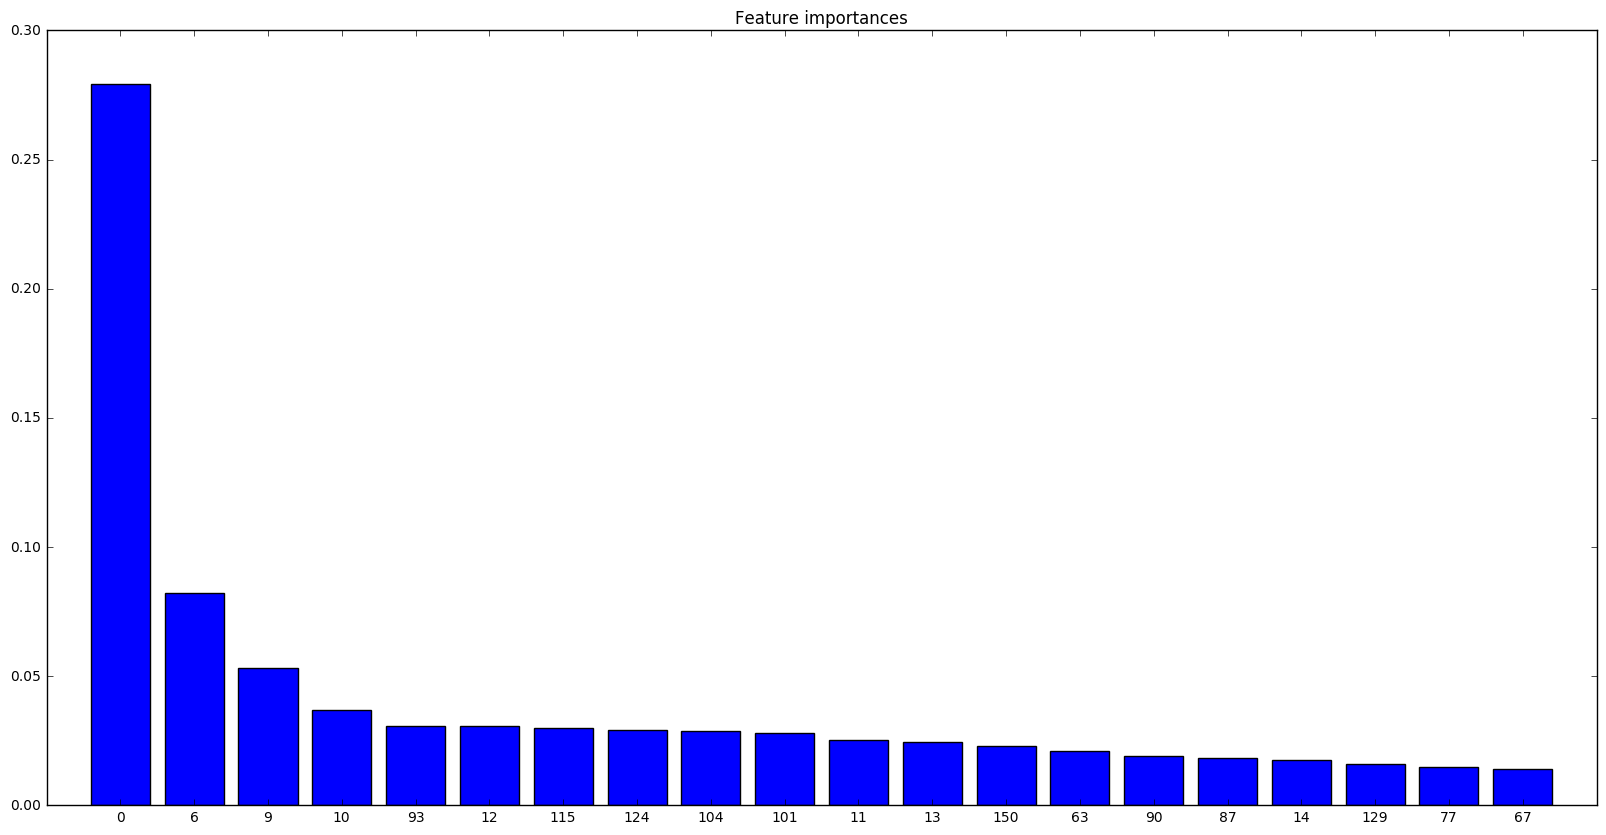

In [9]:
machine_learning_helper.plotFeaturesImportance(model,X_train)

The figure above shows the 20 most important features following the NDCG score. The age feature is by far the most important one. 

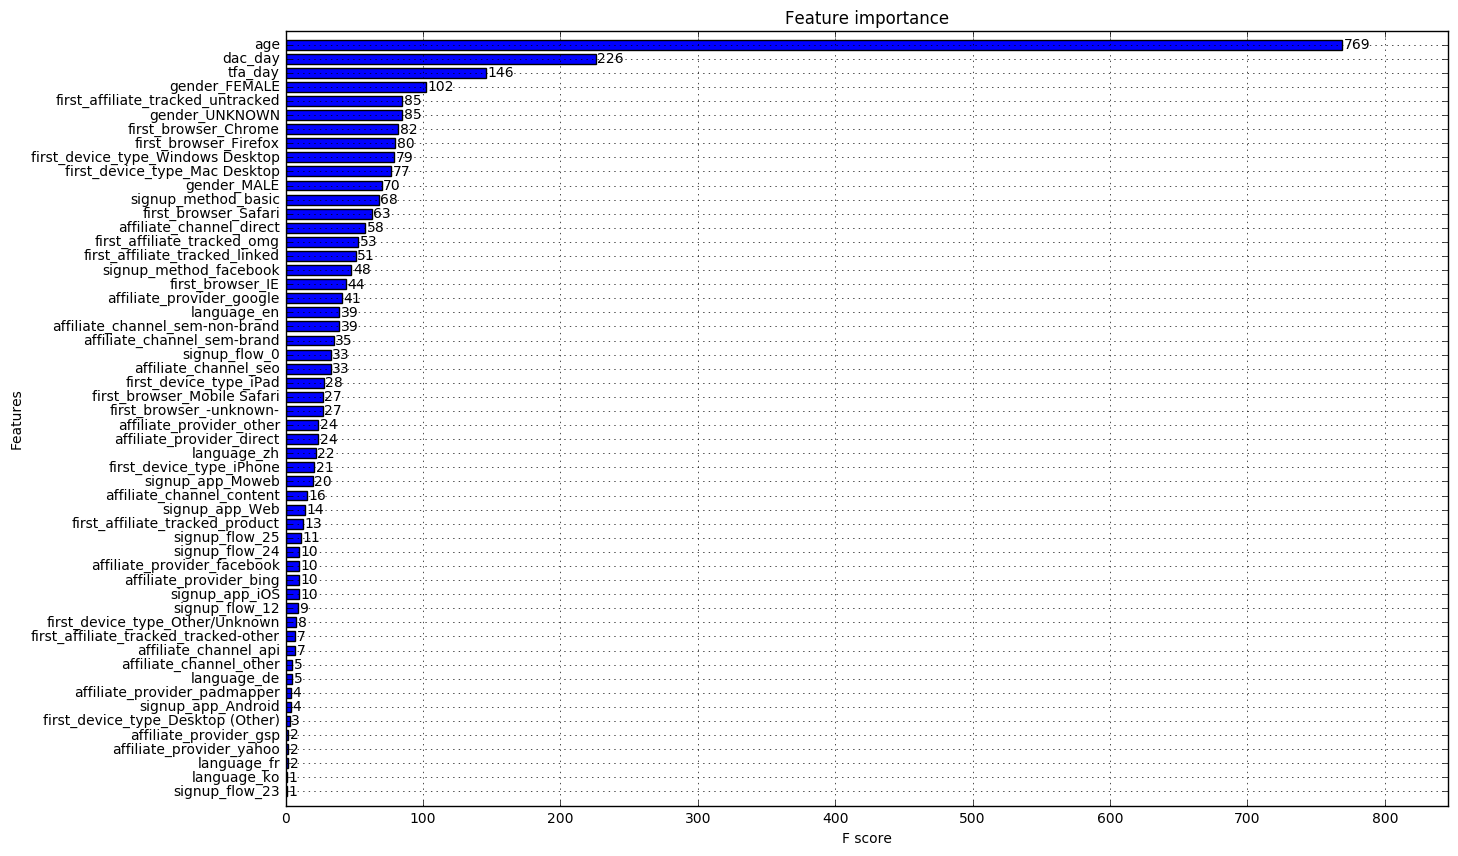

In [10]:
fig, ax = plt.subplots(figsize=(15, 10))
xgb.plot_importance(model,height=0.7, ax=ax)

The figure above shows the most important features using the F score. 
# 6. Evaluating XGB model learning

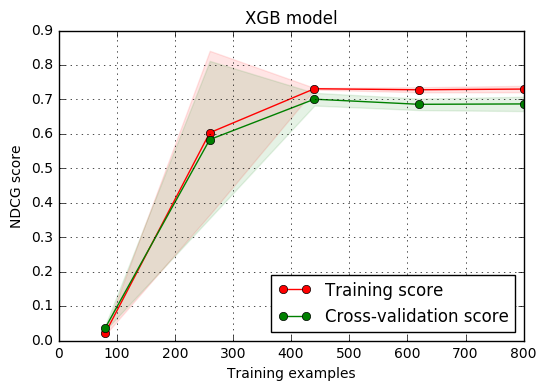

In [11]:
machine_learning_helper.plotLearningCurve(model,X_train,y_labels,cv)

- The learning curve shown below uses a span of 80 to 800 samples from the training data. We couldn't evaluate over the whole data size, but the NDCG score grows higher with our best models and the full training dataset. 
- The figure shows that we are not overfitting on our training dataset

# Conclusion : 
- With our best models, we can predict the destination choosen by Airbnb users with a precision of 0.86967 on the NDCG score.
- The most important features to predict the destination are the age of the user and the day he created his account